# User-User Collaborative Filtering
In this notebook I will perform the task of [lecture 23](https://www.udemy.com/recommender-systems/learn/lecture/11717432), which is to predict movie ratings of users using user-user collaborative filtering.

# MovieLens Data
The data that I will classify comes from the MovieLens20M data set, containing 20 million user ratings (1-5 stars) of movies in the MovieLens database.

## Load the Data

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
movielens_df = pd.read_csv('large_files/rating.csv')

In [3]:
movielens_df.shape

(20000263, 4)

In [4]:
movielens_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
movielens_df.loc[:,['userId', 'movieId']].nunique()

userId     138493
movieId     26744
dtype: int64

## Reduce the data
I would like to avoid having to deal with a 138k X 26k matrix of user-ratings.
The course suggests only considering the top most active users and most rated movies.
For movies this might make sense, we could consider only recommending movies we have a lot of data bout, but when it comes to users I see this as a little bit of a cheat, since it automatically discards the hardest cases, i.e. providing recommendations for users we have little data for.

So, I will be keeping the top most rated movies, but a random subset of users (subject to some limitations).

### Select top movies

In [9]:
top_most_rated_movies = movielens_df['movieId'].value_counts()

Text(0.5,1,'Distribution of ratings for all movies')

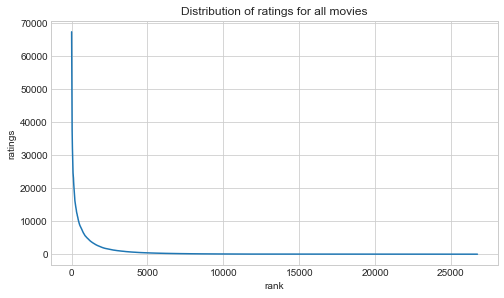

In [16]:
f, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(np.arange(len(top_most_rated_movies)), top_most_rated_movies.values);
ax.set_ylabel('ratings')
ax.set_xlabel('rank')
ax.set_title('Distribution of ratings for all movies')

The number of ratings per movie follows a clear power law, with a small fraction of movies having a large number of ratings. Let's select the top 2,500 movies for our experiments.

In [26]:
top_movies = top_most_rated_movies[:2500].index.values

In [31]:
top_movies_df = movielens_df.loc[movielens_df.loc[:,'movieId'].isin(top_movies),:]

In [36]:
print("We are down to %.2f %% of all reviews" % (100 * top_movies_df.shape[0] / movielens_df.shape[0]))

We are down to 84.85 % of all reviews


### Filter out users

In [37]:
reviews_per_user = top_movies_df['userId'].value_counts()

Text(0.5,1,'Distribution of ratings for all users')

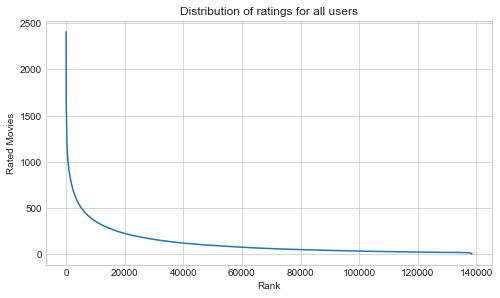

In [39]:
f, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(np.arange(len(reviews_per_user)), reviews_per_user.values);
ax.set_ylabel('Rated Movies')
ax.set_xlabel('Rank')
ax.set_title('Distribution of ratings for all users')

Similar story as before, some users have rated a lot of movies. Tough this distribution has a fatter tail, meaning manu users have actually rated a medium amount of movies.

Anyway, let's only keep 20,000 users to start with. 10,000 for training and 10,000 for a test set.

In [42]:
users_to_keep = np.random.choice(reviews_per_user.index.values, 20000, replace=False)

In [45]:
train_users, test_users = users_to_keep[:10000], users_to_keep[10000:]

In [47]:
train_df = top_movies_df.loc[top_movies_df.loc[:,'userId'].isin(train_users),:]
test_df = top_movies_df.loc[top_movies_df.loc[:,'userId'].isin(test_users),:]

In [49]:
print("Training set consists of %.2f %% of all reviews" % (100 * train_df.shape[0] / movielens_df.shape[0]))
print("Test set consists of %.2f %% of all reviews" % (100 * test_df.shape[0] / movielens_df.shape[0]))

Training set consists of 6.21 % of all reviews
Test set consists of 6.02 % of all reviews


Cool, now the set of reviews we need to handle is drastically reduced.

# Predicting ratings
The task I am tackeling in this notebook is to predict movie ratings for movies that a user did not yet watch. This will be done based on how users with similar taste in movies have rated the movie.

## Sparse Recommendation Matrix 

Give all users a new index staring at 0, for easier storing in matrix format.

In [88]:
train_user_ids = dict(zip(train_df.loc[:,'userId'].unique(), range(train_df.loc[:,'userId'].nunique())))
test_user_ids = dict(zip(test_df.loc[:,'userId'].unique(), range(test_df.loc[:,'userId'].nunique())))

movie_ids = dict(zip(top_movies, range(len(top_movies))))

In [89]:
# Relabel Users
train_df.loc[:,'newUserId'] = train_df.loc[:,'userId'].apply(lambda x: train_user_ids[x])
test_df.loc[:,'newUserId'] = test_df.loc[:,'userId'].apply(lambda x: test_user_ids[x])

# Relabel Movies
train_df.loc[:,'newMovieId'] = train_df.loc[:,'movieId'].apply(lambda x: movie_ids[x])
test_df.loc[:,'newMovieId'] = test_df.loc[:,'movieId'].apply(lambda x: movie_ids[x])

C:\Users\Gustav\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Gustav\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [50]:
import scipy

In [90]:
R_train = scipy.sparse.coo_matrix((train_df.loc[:,'rating'].values, (train_df.loc[:,'newUserId'].values, train_df.loc[:,'newMovieId'].values)), shape=(10000, 2500))
R_train = scipy.sparse.csr_matrix(R_train)

In [96]:
R_test = scipy.sparse.coo_matrix((test_df.loc[:,'rating'].values, (test_df.loc[:,'newUserId'].values, test_df.loc[:,'newMovieId'].values)), shape=(10000, 2500))
R_test = scipy.sparse.csr_matrix(R_test)

## Un-weighted averages
First, let's make predictions $\hat{r}_{i,j}$ about what ratings user $i$ will give movie $j$ simply by averaging over all other predictions:
$$\hat{r}_{i,j}= \bar{r}_i + \frac{\sum_{i'\in \Omega_j}r_{i',j} - \bar{r}_{i'}}{|\Omega_j|},$$
where $r_{i,j}$ is the rating given by user $i$ for movie $j$, $\bar{r}_i$ is the average of all ratings user $i$ has given so far, $\Omega_j$ is the set of all users who have rated movie $j$.
Esentially, we predict ratings for each user-movie pair as the users mean rating plus the movies average deviation from raters mean ratings.

Start by calculating the avereage rating for all users: $\bar{r}_i$

In [168]:
# Rhat
R_train_user_mean = R_train.sum(1) / (R_train != 0).sum(1)
R_train_user_mean_vec = np.asarray(R_train_user_mean).reshape(-1)

Calculating $\frac{\sum_{i'\in \Psi_j}r_{i',j} - \bar{r}_{i'}}{|\Psi_j|}$ is trickier since it requires subtracting the row means only from non-zero ratings:

In [200]:
# Elementwise subtraction of the user means (adapted from https://stackoverflow.com/questions/19017804/scipy-sparse-matrix-special-substraction)
non_zero_per_row = np.diff(R_train.indptr)

R_train_deviations = scipy.sparse.csr_matrix((R_train.data - np.repeat(R_train_user_mean_vec, non_zero_per_row), R_train.indices, R_train.indptr),
                   shape=R_train.shape)

R_train_movie_mean_deviations = R_train_movie_mean_dev.sum(0) / (R_train != 0).sum(0)

Finaly, piece the two vectors together to calculate the matrix $\hat{R}$, with elements $\bar{r}_{i,j}$.

In [201]:
R_train_predictions = R_train_user_mean + R_train_movie_mean_deviations

Though, since we can only evaluate movies that users have actually rated, let's also create a vector of predictions that we call $\hat{Y}$, that we can use to compare to the ectual reviews $Y$.

In [188]:
Y_train_hat = np.asarray(R_train_predictions[R_train.nonzero()]).reshape(-1)

In [189]:
Y_train_hat.shape

(1241462,)

In [192]:
Y_train = R_train.data

In [193]:
Y_train.shape

(1241462,)

### Evaluate with MSE

In [183]:
from sklearn.metrics import mean_squared_error

In [195]:
print("MSE on training set, no weighting: %.4f" % mean_squared_error(Y_train, Y_train_hat))

MSE on training set, no weighting: 0.7395


## Weighted averages
When predicting ratings with weighted averages, we consider the ratings made by similar users as being more relevant. Predictions are made with:
$$\hat{r}_{i,j}= \bar{r}_i + \frac{\sum_{i'\in \Omega_j}w_{i,i'}(r_{i',j} - \bar{r}_{i'})}{\sum_{i'\in\Omega_j}|w_{i,i'}|},$$
where $w_{i,i'}$ is a weight how how similar users $i$ and $i'$ are.

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

In [202]:
W_train = cosine_similarity(R_train_deviations)

In [205]:
W_train.shape

(10000, 10000)

First, a naive implementation of the predict function that simply predicts the rating for a single user-movie pair.

In [323]:
def pred(user_id, movie_id, R_deviations, W, R_user_mean):
    
    return (R_user_mean[user_id] + (W[user_id] * R_deviations[:,movie_id].toarray().flatten()).sum() / np.absolute(W[user_id]).sum())

The above implementation ended up being increadibly slow, so let's improve it by calculating all predictions for one user at a time.

In [339]:
def pred_user(user_id, R_deviations, W, R_user_mean):
    weighted_deviations = R_deviations.T.multiply(W[user_id]).T
    
    return R_user_mean[user_id] + weighted_deviations.sum(0) / np.absolute(W[0]).sum(0)

In [332]:
pred(0, 10, R_train_deviations, W_train, R_train_user_mean_vec)

3.9692634523529975

In [340]:
pred_user(0, R_train_deviations, W_train, R_train_user_mean_vec)[0,10]

3.9692634523529975

In [289]:
from tqdm import tqdm

In [342]:
%%time
R_train_predictions_weighted = np.zeros((10000, 2500))
for i in tqdm(range(10000)):
    R_train_predictions_weighted[i,:] = pred_user(i, R_train_deviations, W_train, R_train_user_mean)


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:30<00:00, 11.48it/s]


Wall time: 14min 30s


In [343]:
Y_train_hat_weighted = np.asarray(R_train_predictions_weighted[R_train.nonzero()]).reshape(-1)

Now that I am weighting contributions to the prediction based on user similarities, I expect results to be better.
However, for the training set the effect will probably be inflated, since users will de deemed to be very similar to themselves, and thus leak their actual ratings into the predictions to a larger extend compared to when no weights were used.

In [344]:
print("MSE on training set, with user similarity weighting: %.4f" % mean_squared_error(Y_train, Y_train_hat_weighted))

MSE on training set, with user similarity weighting: 0.7890


Hmm, thsi result is actually worse compared to that of simply taking the average, and it came at a significant computational cost...

Let's see what happens if we only consider the k closest neighbours to a user when making predictions.

In [360]:
def pred_user_from_k_neighbours(user_id, R_deviations, W, R_user_mean, k):
    
    # Since we are filtering out users, let's also filter out the actual user we are predicting.
    k_closest_users = np.argpartition(W[user_id], -k-1)[-k-1:]
    k_closest_users = np.delete(k_closest_users, np.where(k_closest_users == user_id))
    
    weighted_deviations = R_deviations[k_closest_users].T.multiply(W[user_id,k_closest_users]).T
    
    return R_user_mean[user_id] + np.nan_to_num((weighted_deviations.sum(0) / np.absolute(W[user_id,k_closest_users]).sum(0)), 0)

In [361]:
pred_user_from_k_neighbours(0, R_train_deviations, W_train, R_train_user_mean_vec, 50)[0,10]

3.914548393149484

In [362]:
%%time
R_train_predictions_neighbours = np.zeros((10000, 2500))
for i in tqdm(range(10000)):
    R_train_predictions_neighbours[i,:] = pred_user_from_k_neighbours(i, R_train_deviations, W_train, R_train_user_mean, 50)


 30%|██████████████████████▉                                                     | 3023/10000 [00:05<00:11, 597.61it/s]C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 623.28it/s]


Wall time: 16.1 s


In [368]:
Y_train_hat_neighbours = np.asarray(R_train_predictions_neighbours[R_train.nonzero()]).reshape(-1)
print("MSE on training set, with user similarity weighting and 50 neighbours: %.4f" % mean_squared_error(Y_train, Y_train_hat_neighbours))

MSE on training set, with user similarity weighting and 50 neighbours: 0.6629


Improvement! And the computational cost is also much lower comapred to taking the full weighted average. Also, this is actually the first method where I did not allow the model to peek at the users own ratings.

Anyway, we should not evaluate on the test set, let's try the test set instead.

# Test set evaluations

## Un-weighted

In [364]:
# Rhat
R_test_user_mean = R_test.sum(1) / (R_test != 0).sum(1)
R_test_user_mean_vec = np.asarray(R_test_user_mean).reshape(-1)

In [365]:
R_test_predictions = R_test_user_mean + R_train_movie_mean_deviations

Though, since we can only evaluate movies that users have actually rated, let's also create a vector of predictions that we call $\hat{Y}$, that we can use to compare to the ectual reviews $Y$.

In [366]:
Y_test_hat = np.asarray(R_test_predictions[R_test.nonzero()]).reshape(-1)

In [370]:
Y_test = R_test.data

In [371]:
print("MSE on test set, without weights: %.4f" % mean_squared_error(Y_test, Y_test_hat))

MSE on test set, without weights: 0.8899


Worse than the training result, as expected!

## Weighted

We didn't need the test set deviations for the un-weighted approach, but now we need them to calculate user similarities.

In [372]:
# Elementwise subtraction of the user means (adapted from https://stackoverflow.com/questions/19017804/scipy-sparse-matrix-special-substraction)
non_zero_per_row = np.diff(R_test.indptr)

R_test_deviations = scipy.sparse.csr_matrix((R_test.data - np.repeat(R_test_user_mean_vec, non_zero_per_row), R_test.indices, R_test.indptr),
                   shape=R_test.shape)

Calculate similarity of users in the test set and the training set. $W_{i,j}$ will be the similarity of user $i$ in the test set and user $j$ in the training set.

In [378]:
W_test = cosine_similarity(R_test_deviations, R_train_deviations)

In [379]:
W_test.shape

(10000, 10000)

Predictions should be made based on the average rating of a user in the test set, it's similarity to users in the training set, and the ratings users in the training set has made.

In [380]:
pred(0, 10, R_train_deviations, W_test, R_test_user_mean_vec)

4.0367859266880854

In [381]:
%%time
R_test_predictions_weighted = np.zeros((10000, 2500))
for i in tqdm(range(10000)):
    R_test_predictions_weighted[i,:] = pred_user(i, R_train_deviations, W_test, R_test_user_mean)


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [11:53<00:00, 14.02it/s]


Wall time: 11min 53s


In [383]:
Y_test_hat_weighted = np.asarray(R_test_predictions_weighted[R_test.nonzero()]).reshape(-1)

In [384]:
print("MSE on testing set, with user similarity weighting: %.4f" % mean_squared_error(Y_test, Y_test_hat_weighted))

MSE on testing set, with user similarity weighting: 0.7660


Wow, this is actually a better result compared to what we got on the training set. Fishy...

We need to modify the k-neighbour approach, since it is no longer relevant to filter out the user we are predicting ratings for.

In [385]:
def pred_user_from_k_neighbours_test(user_id, R_deviations, W, R_user_mean, k):
    
    k_closest_users = np.argpartition(W[user_id], -k)[-k:]
    
    weighted_deviations = R_deviations[k_closest_users].T.multiply(W[user_id,k_closest_users]).T
    
    return R_user_mean[user_id] + np.nan_to_num((weighted_deviations.sum(0) / np.absolute(W[user_id,k_closest_users]).sum(0)), 0)

In [386]:
%%time
R_test_predictions_neighbours = np.zeros((10000, 2500))
for i in tqdm(range(10000)):
    R_test_predictions_neighbours[i,:] = pred_user_from_k_neighbours(i, R_train_deviations, W_test, R_test_user_mean, 50)


 11%|████████▋                                                                   | 1139/10000 [00:01<00:15, 589.86it/s]C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 623.37it/s]


Wall time: 16 s


In [387]:
Y_test_hat_neighbours = np.asarray(R_test_predictions_neighbours[R_test.nonzero()]).reshape(-1)
print("MSE on testing set, with user similarity weighting and 50 neighbours: %.4f" % mean_squared_error(Y_test, Y_test_hat_neighbours))

MSE on testing set, with user similarity weighting and 50 neighbours: 0.6580


Hmm, again we see better results compared to what we got on the training set...

Let's see what happens with fewer neighbours:

In [389]:
%%time
R_test_predictions_neighbours_25 = np.zeros((10000, 2500))
for i in tqdm(range(10000)):
    R_test_predictions_neighbours_25[i,:] = pred_user_from_k_neighbours(i, R_train_deviations, W_test, R_test_user_mean, 25)


 11%|████████▋                                                                   | 1141/10000 [00:01<00:14, 624.92it/s]C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 605.77it/s]


Wall time: 16.5 s


In [390]:
Y_test_hat_neighbours_25 = np.asarray(R_test_predictions_neighbours_25[R_test.nonzero()]).reshape(-1)
print("MSE on testing set, with user similarity weighting and 25 neighbours: %.4f" % mean_squared_error(Y_test, Y_test_hat_neighbours_25))

MSE on testing set, with user similarity weighting and 25 neighbours: 0.6493


Even better!

Still, I find it very fishy that we get better results on the test set compared to the training set.